In [2]:
%matplotlib inline
import matplotlib.style as style

import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm

import scqubits as scq
import qutip as qt

from PulseSequence import PulseSequence
from QSwitch import QSwitch

style.use('default')
plt.rcParams['figure.figsize'] = [9.7, 6]
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
scq.settings.PROGRESSBAR_DISABLED = True

In [3]:
hbar = 1.054e-34
h = hbar*2*np.pi
qe = 1.602e-19
red_flux_quant = hbar/2/qe 

# Unit conversions
MHz = 10.0**(-3)
GHz = 1.0
kHz = 10.0**(-6)
us = 10.0**3
ns = 1.0

In [4]:
# q_in, q_switch, q_out1, q_out2
# EJs = [21, 20, 22, 21.5]
# ECs = [0.25, 0.35, 0.35, 0.28]
# gs = [0.1, 0.1, 0.1] # g12, g23, g24
EJs = [14, 15, 13, 18]
ECs = [0.25, 0.32, 0.20, 0.28]
gs = [0.045, 0.055, 0.055] # g12, g23, g24

cutoffs = [4, 5, 4, 4]
isCavity = [False, False, False, False]

qram = QSwitch(
    EJs=EJs,
    ECs=ECs,
    gs=gs,
    cutoffs=cutoffs,
    isCavity=isCavity,
)

qubit_freqs = qram.qubit_freqs
alphas = qram.alphas
print('qubit freqs (GHz)', *qubit_freqs)
print('alphas (GHz)', *alphas)


print('capacitances (fF)', *(qe**2/(2*h*np.array(ECs)*1e9)*1e15))
print('lumped L (nH)', *(red_flux_quant**2/h/np.array(EJs)))

qubit freqs (GHz) 5.027909182915874 5.857471635676067 4.3507218827523575 6.0557426370702085
alphas (GHz) -0.28449169928763673 -0.37003033624567827 -0.22500175260814181 -0.315254707324252
capacitances (fF) 77.50586007036293 60.551453179971034 96.88232508795365 69.20166077710975
lumped L (nH) 11.672064854924972 10.893927197929974 12.56991599761151 9.078272664941645


In [53]:
# MAKE SURE DRESSED STATES ARE MAPPED CORRECTLY, AT LEAST FOR <= n EXCITATIONS
# qram.check_state_mapping(n=3)

In [64]:
seq = PulseSequence(start_time=0)
# wd1 = qram.add_sequential_pi_pulse(seq, 'eggg', 'gfgg', amp=0.17)
# wd2 = qram.add_sequential_pi_pulse(seq, 'eegg', 'eggg', amp=0.01)
# wd3 = qram.add_sequential_pi_pulse(seq, 'gfgg', 'ggeg', amp=0.08)
# wd4 = qram.add_sequential_pi_pulse(seq, 'eggg', 'gfgg', wd=wd1, amp=0.17)
# wd5 = qram.add_sequential_pi_pulse(seq, 'ggeg', 'geeg', amp=0.01) # should be same as wd2
# wd6 = qram.add_sequential_pi_pulse(seq, 'gfgg', 'ggge', amp=0.01)
# wd7 = qram.add_sequential_pi_pulse(seq, 'ggge', 'gege', amp=0.01) # should be same as wd2 and should also drive geeg -> ggeg


print('wd1')
wd1 = qram.add_sequential_pi_pulse(seq, 'eggg', 'gfgg', amp=0.10, drive_qubit=1)
print('wd2')
wd2 = qram.add_sequential_pi_pulse(seq, 'eegg', 'eggg', amp=0.07, drive_qubit=1)
print('wd3')
wd3 = qram.add_sequential_pi_pulse(seq, 'gfgg', 'ggeg', amp=0.15, drive_qubit=1)
print('wd4')
# wd4 = qram.add_sequential_pi_pulse(seq, 'eggg', 'gfgg', amp=0.10, drive_qubit=1)
wd4 = qram.add_sequential_pi_pulse(seq, 'eggg', 'gfgg', amp=0.10, drive_qubit=1, wd=wd1)
print('wd5')
wd5 = qram.add_sequential_pi_pulse(seq, 'ggeg', 'geeg', amp=0.07, drive_qubit=1)
print('wd6')
wd6 = qram.add_sequential_pi_pulse(seq, 'gfgg', 'ggge', amp=0.05, drive_qubit=1)
print('wd7')
wd7 = qram.add_sequential_pi_pulse(seq, 'ggge', 'gege', amp=0.07, drive_qubit=1)

wd1
	new overlap 0.8725955834503516 wd 39.72646797928614
	new overlap 0.9453356723787307 wd 39.676467979286144
	new overlap 0.9862479974183065 wd 39.69646797928615
	new overlap 0.9873483139624207 wd 39.694467979286145
updated drive freq (GHz) from 6.3226637504852885 to 6.317570792306348
wd2
	new overlap 0.985034607012211 wd 36.711001630459876
	new overlap 0.9882885014591033 wd 36.76100163045987
	new overlap 0.9882885014591026 wd 36.76100163045987
	new overlap 0.9883283702585229 wd 36.757001630459875
updated drive freq (GHz) from 5.842737375342319 to 5.850058502724545
wd3
	new overlap 0.7905183272036613 wd 43.97873422471936
	new overlap 0.7905183272036613 wd 43.97873422471936
	new overlap 0.9914194939673406 wd 43.95873422471936
updated drive freq (GHz) from 6.9994329427888 to 6.996249843926962
wd4
wd5
	new overlap 0.9866058735597516 wd 36.729821785813485
	new overlap 0.9894249518060485 wd 36.77982178581348
	new overlap 0.9894649724702056 wd 36.769821785813484
	new overlap 0.989486457223

In [65]:
# CHECK FOR CLASHING LEVELS
tolerance = 20*MHz
problem_pulses = qram.check_level_resonances(seq, tolerance=tolerance)
good_freqs = seq.get_pulse_freqs(simplified=True)
if len(problem_pulses.items()) == 0:
    print(f'No clashes found within {tolerance} GHz!')
for good_pulse, problem_pulse_dict in problem_pulses.items():
    print('Clashes to', tolerance,'GHz with', good_pulse[0], '<->', good_pulse[1], f'(freq = {good_freqs[good_pulse]})')
    for problem_pulse, freq in problem_pulse_dict.items():
        diff_freq = np.abs(freq-good_freqs[good_pulse])                   
        if diff_freq > tolerance:
            diff_freq = np.abs(2*freq-good_freqs[good_pulse])
        print('\t', problem_pulse[0], '<->', problem_pulse[1], freq, f'(off by {diff_freq})')

No clashes found within 0.02 GHz!


[6.317570792306348, 5.850058502724545, 6.996249843926962, 6.317570792306348, 5.852735513592646, 5.295755325524216, 5.902915095215546] (GHz)
[81.90867238037316, 7.394673021613282, 202.6324691289373, 81.90867238037316, 7.397564391587315, 45.31757569359975, 7.83984990027811] (ns)
total pulse length 434.39947689676205 ns


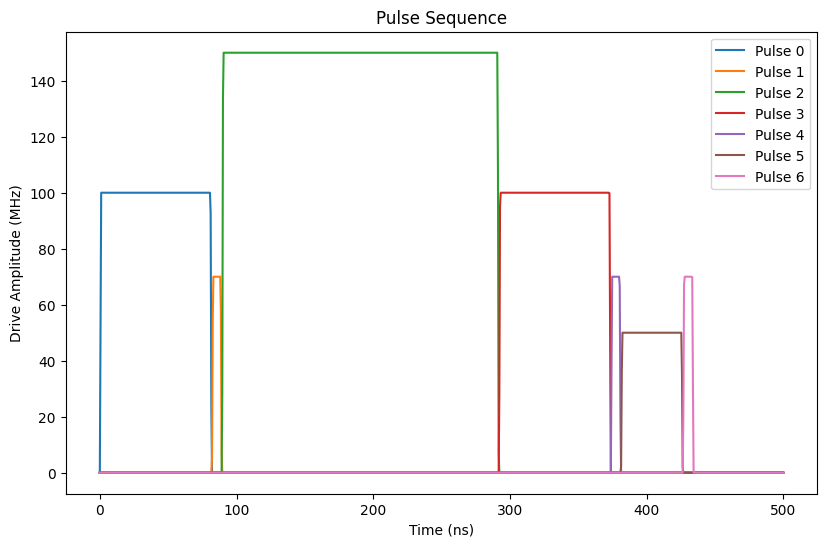

In [68]:
times = np.linspace(0, 500, 1000)
# times = np.linspace(0, 750, 1000)
# times = np.linspace(0, 300, 700)
# times = np.linspace(0, 50, 100)

envelope_seq = seq.get_envelope_seq()
print(seq.get_pulse_freqs(), '(GHz)')
print(seq.get_pulse_lengths(), '(ns)')
print('total pulse length', sum(seq.get_pulse_lengths()), 'ns')
for i in range(len(envelope_seq)):
    plt.plot(times, [envelope_seq[i](t)/MHz for t in times], label=f'Pulse {i}')
plt.xlabel('Time (ns)')
plt.ylabel('Drive Amplitude (MHz)')
plt.title('Pulse Sequence')
plt.legend()
plt.show()

In [69]:
# incl_dissipation = True
incl_dissipation = False

T1 = 60e3 # ns
T2 = 30e3 # ?

# T1 = 10e3

c_ops = [
    np.sqrt(1/T1)*qram.a,
    np.sqrt(1/T1)*qram.b,
    np.sqrt(1/T1)*qram.c,
    np.sqrt(1/T1)*qram.d,
]

In [70]:
# psi0_name = 'eggg'
# psi0_name = 'gfgg'
# psi0_name = 'efgg'
# psi0_name = 'eegg'
# psi0_name = 'ggeg'
# psi0_name = 'ggge'

# psi0 = qram.state(psi0_name)
psi0 = np.sqrt(0.4) * qram.state('eggg') + np.sqrt(0.6) * qram.state('eegg') # QRAM start
# psi0 = np.sqrt(0.4) * qram.state('gggg') + np.sqrt(0.6) * qram.state('gegg') # QRAM start

# print(seq.get_pulse_str())

if incl_dissipation:
    full_result = qt.mcsolve(qram.H_solver_str(seq), psi0, times, c_ops, progress_bar=True, options=qt.Options(nsteps=10000))
    result = np.sum(full_result.states, axis=0)/full_result.ntraj
else:
    # result = qt.mesolve(qram.H_solver(seq), psi0, times, progress_bar=True, options=qt.Options(nsteps=10000)).states
    result = qt.mesolve(qram.H_solver_str(seq), psi0, times, progress_bar=True, options=qt.Options(nsteps=12000)).states

10.0%. Run time:  13.40s. Est. time left: 00:00:02:00
20.0%. Run time:  26.58s. Est. time left: 00:00:01:46
30.0%. Run time:  39.22s. Est. time left: 00:00:01:31
40.0%. Run time:  51.54s. Est. time left: 00:00:01:17
50.0%. Run time:  64.11s. Est. time left: 00:00:01:04
60.0%. Run time:  76.76s. Est. time left: 00:00:00:51
70.0%. Run time:  89.10s. Est. time left: 00:00:00:38
80.0%. Run time: 102.25s. Est. time left: 00:00:00:25
90.0%. Run time: 117.68s. Est. time left: 00:00:00:13
Total run time: 133.08s


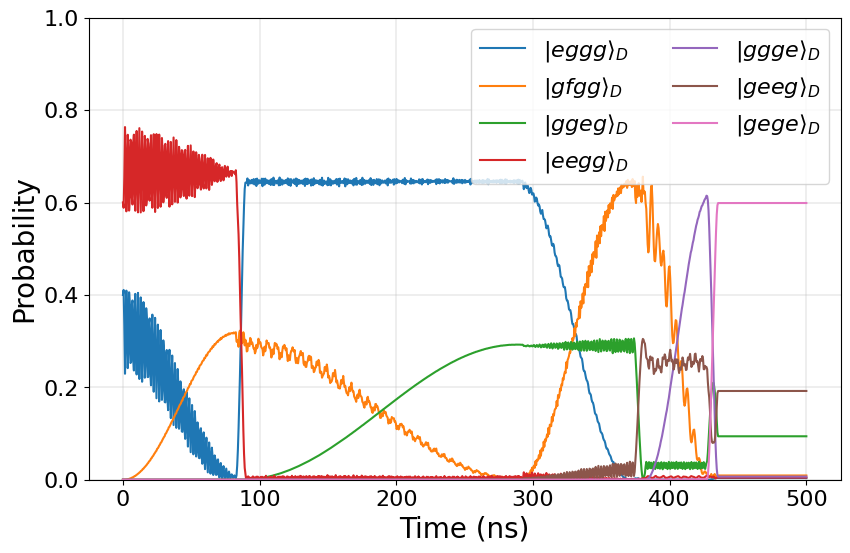

In [71]:
# states for 1 input
eggg = qram.state('eggg')
gfgg = qram.state('gfgg')
ggeg = qram.state('ggeg')
eegg = qram.state('eegg')
ggge = qram.state('ggge')
geeg = qram.state('geeg')
gege = qram.state('gege')
prob_eggg = [np.abs(eggg.overlap(result[t]))**2 for t in range(len(times))]
prob_gfgg = [np.abs(gfgg.overlap(result[t]))**2 for t in range(len(times))]
prob_ggeg = [np.abs(ggeg.overlap(result[t]))**2 for t in range(len(times))]
prob_eegg = [np.abs(eegg.overlap(result[t]))**2 for t in range(len(times))]
prob_ggge = [np.abs(ggge.overlap(result[t]))**2 for t in range(len(times))]
prob_geeg = [np.abs(geeg.overlap(result[t]))**2 for t in range(len(times))]
prob_gege = [np.abs(gege.overlap(result[t]))**2 for t in range(len(times))]

# states for 0 input
gggg = qram.state('gggg')
gegg = qram.state('gegg')
prob_gggg = [np.abs(gggg.overlap(result[t]))**2 for t in range(len(times))]
prob_gegg = [np.abs(gegg.overlap(result[t]))**2 for t in range(len(times))]


plt.plot(times, prob_eggg, label=r'$|eggg\rangle_D$')
plt.plot(times, prob_gfgg, label=r'$|gfgg\rangle_D$')
plt.plot(times, prob_ggeg, label=r'$|ggeg\rangle_D$')
plt.plot(times, prob_eegg, label=r'$|eegg\rangle_D$')
plt.plot(times, prob_ggge, label=r'$|ggge\rangle_D$')
plt.plot(times, prob_geeg, label=r'$|geeg\rangle_D$')
plt.plot(times, prob_gege, label=r'$|gege\rangle_D$')

# plt.plot(times, prob_gggg, label=r'$|gggg\rangle_D$')
# plt.plot(times, prob_gegg, label=r'$|gegg\rangle_D$')

# plt.plot(times, [np.abs(state('geeg').overlap(result[t]))**2 for t in range(len(times))], 'k--', label=r'$|geeg\rangle_D$')
# plt.plot(times, [np.abs(state('efgg').overlap(result[t]))**2 for t in range(len(times))], 'k-.', label=r'$|efgg\rangle_D$')

# for i1 in range(cutoffs[0]):
#     for i2 in range(cutoffs[1]):
#         for i3 in range(cutoffs[2]):
#             for i4 in range(cutoffs[3]):
#                 # print(qram.levels_nums_to_name([i1, i2, i3, i4]))
#                 plt.plot(times, 
#                          [np.abs(qram.state([i1, i2, i3, i4]).overlap(result[t]))**2 for t in range(len(times))],
#                          label='qram.level_nums_to_name[i1, i2, i3, i4]')

# plt.plot(times, [0.5]*len(times), 'k--', linewidth=0.5)
plt.legend(fontsize=16, ncol=2)
plt.ylim(0, 1)
# plt.xlim(750, 1000)
plt.tick_params(labelsize=16)
plt.xlabel('Time (ns)', fontsize=20)
plt.ylabel('Probability', fontsize=20)
# plt.title(r'$\psi_0=|$'+psi0_name+r'$\rangle$')
# plt.title('QRAM state evolution in memory access operation')
plt.grid(linewidth=0.3)
plt.show()

In [36]:
T = 30 # ns

sum_psi = 0
T = np.argmin(np.abs(times-T))
probs = dict()
print("Non-zero levels:")
for i1 in range(cutoffs[0]):
    for i2 in range(cutoffs[1]):
        for i3 in range(cutoffs[2]):
            for i4 in range(cutoffs[3]):
                prob = np.abs(qram.state([i1, i2, i3, i4]).overlap(result[T]))**2
                sum_psi += prob
                if prob > 0.01:
                    probs.update({qram.level_nums_to_name([i1, i2, i3, i4]):prob})
probs = sorted(probs.items(), key=lambda item:-item[1])
for level, prob in probs:
    print(level, prob)
print('Sum probabilities:', sum_psi)

Non-zero levels:
eegg 0.6777368568507433
eggg 0.3006184807431125
gfgg 0.01976445714818161
Sum probabilities: 1.0000000000153317


In [12]:
print('want', qram.get_base_wd('eggg', 'gfgg')/2/np.pi)
print('want', qram.get_base_wd('eegg', 'eggg')/2/np.pi)
# print('want', qram.get_wd('eggg', 'gfgg', 0.10, verbose=False)/2/np.pi)
# print('want', qram.get_wd('eegg', 'gfgg', 0.10, verbose=False)/2/np.pi)
# print('want', qram.get_wd('ggge', 'gege', 0.05, verbose=False)/2/np.pi)
# print('resonant to', qram.get_wd('ggeg', 'geeg', 0.05)/2/np.pi)
# print('2 photon transition to', qram.get_base_wd('eggg', 'efgg')/2/np.pi)

want 6.2192120533711
want 5.874104473311355
